# WOFOST 7.2

In [177]:
%matplotlib inline
import sys
import copy
import datetime as dt
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from xgboost import XGBRegressor, XGBRFRegressor 
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.10.14 (main, Jul 16 2024, 22:12:21) [GCC 9.4.0]
PCSE version: 5.5.6


# Noise-free ground truth

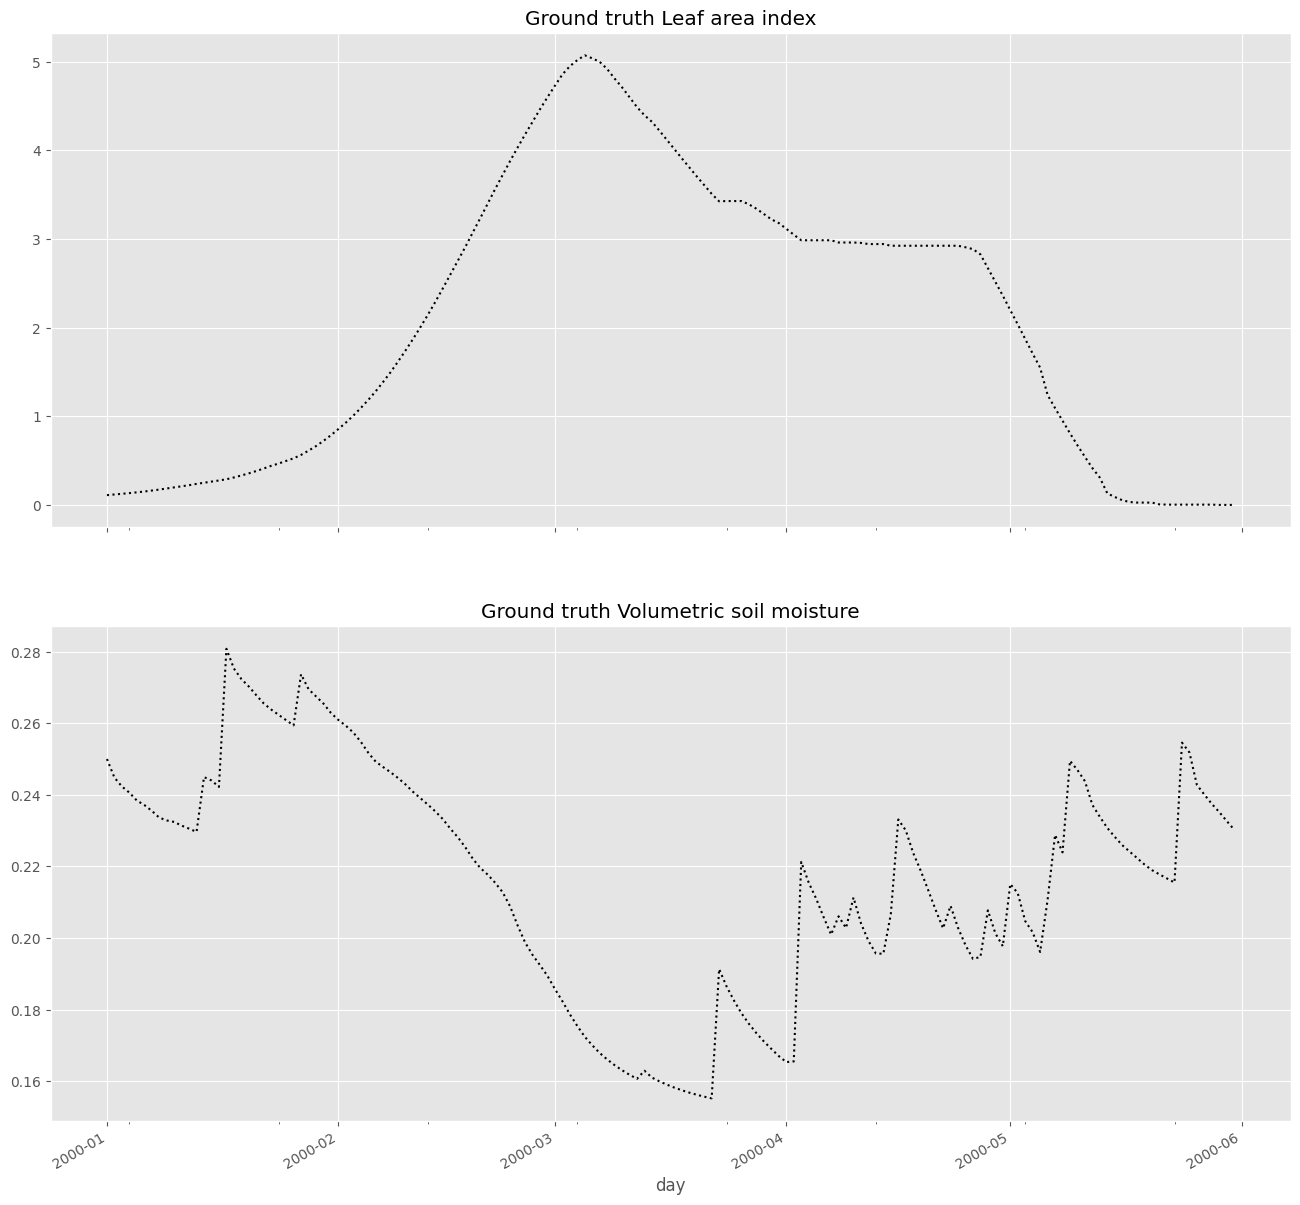

In [2]:
true_params = {}
true_params["TDWI"] = 160
true_params["WAV"] = 5
true_params["SPAN"] = 33
true_params["SMFCF"] = .33

p = copy.deepcopy(parameters)
for par, distr in true_params.items():
    p.set_override(par, distr)
ground_truth = Wofost72_WLP_FD(p, weather, agromanagement)
ground_truth.run_till_terminate()

observed_df = pd.DataFrame(ground_truth.get_output()).set_index("day")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
observed_df["LAI"].plot(style="k:", ax=axes[0])
observed_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Ground truth Leaf area index")
axes[1].set_title("Ground truth Volumetric soil moisture")
fig.autofmt_xdate()

# Monte Carlo simulation

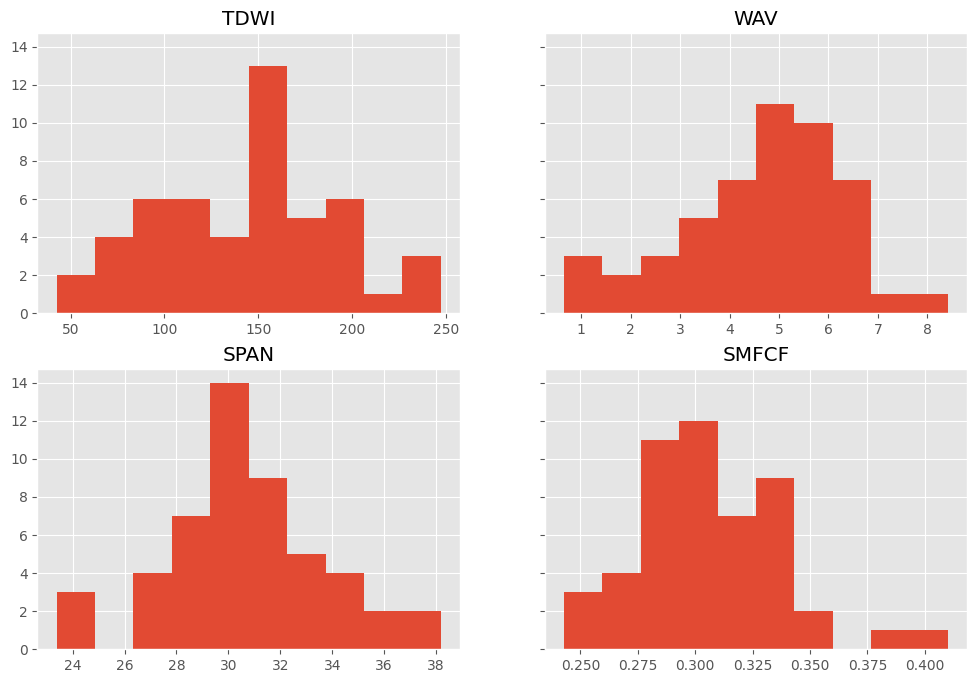

In [3]:
ensemble_size = 50
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

# Ensemble (without assimilation)

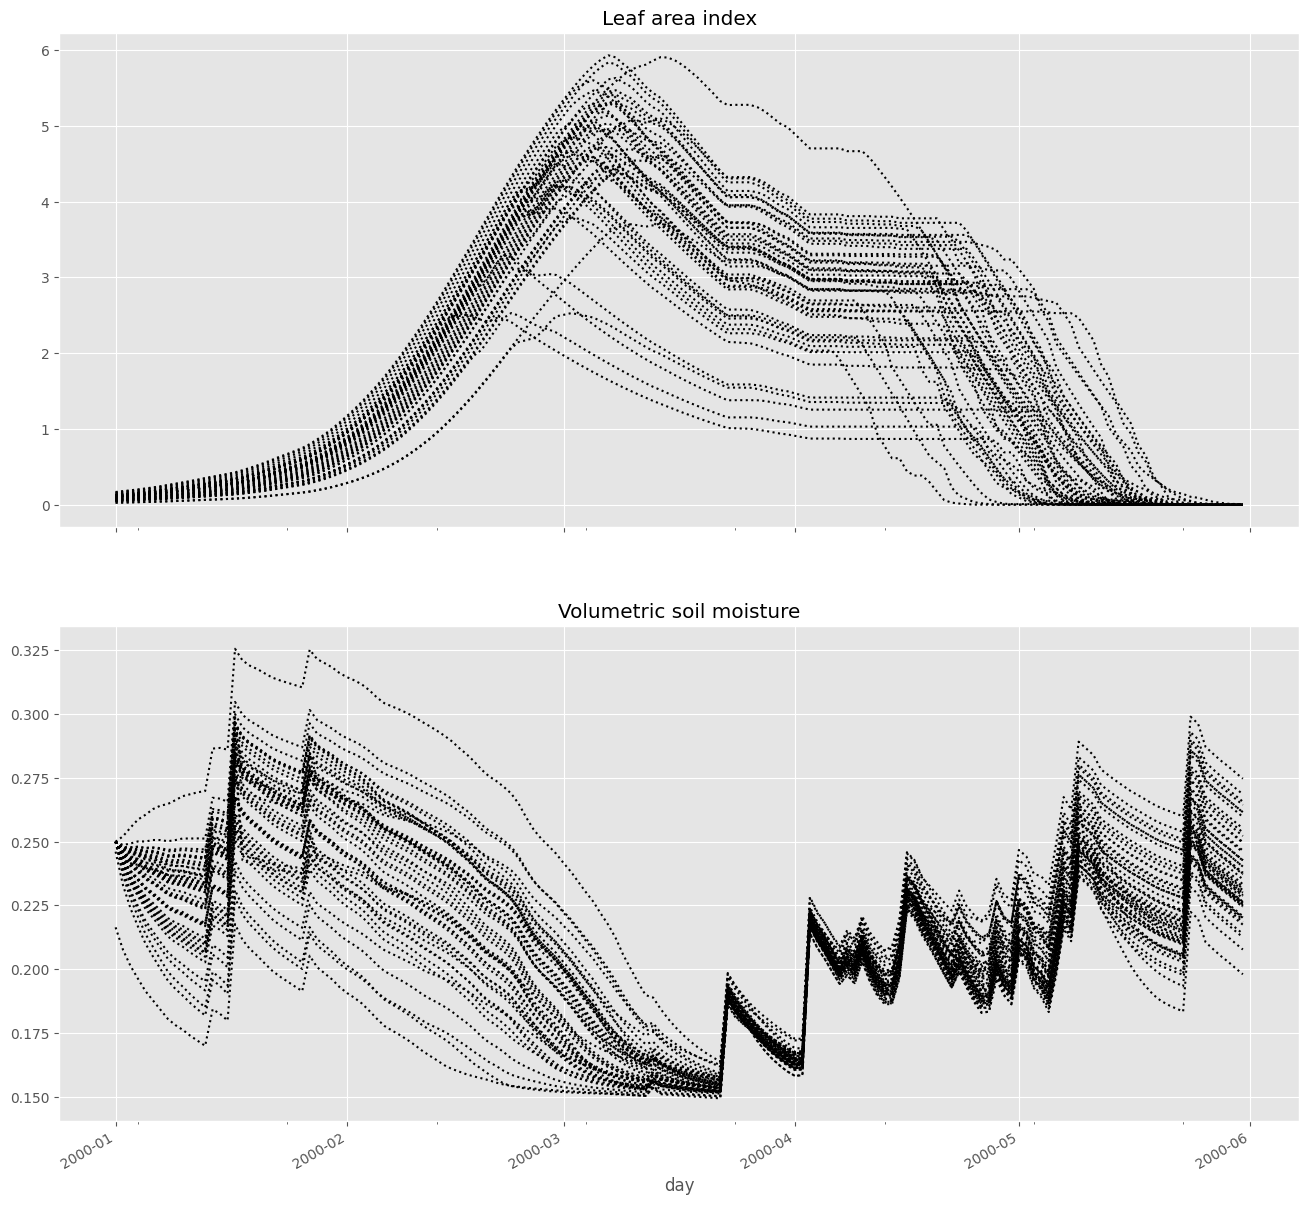

In [4]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

show_output = True
for member in ensemble:
    member.run_till_terminate()

results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

# Ensemble quantiles (without assimilation)

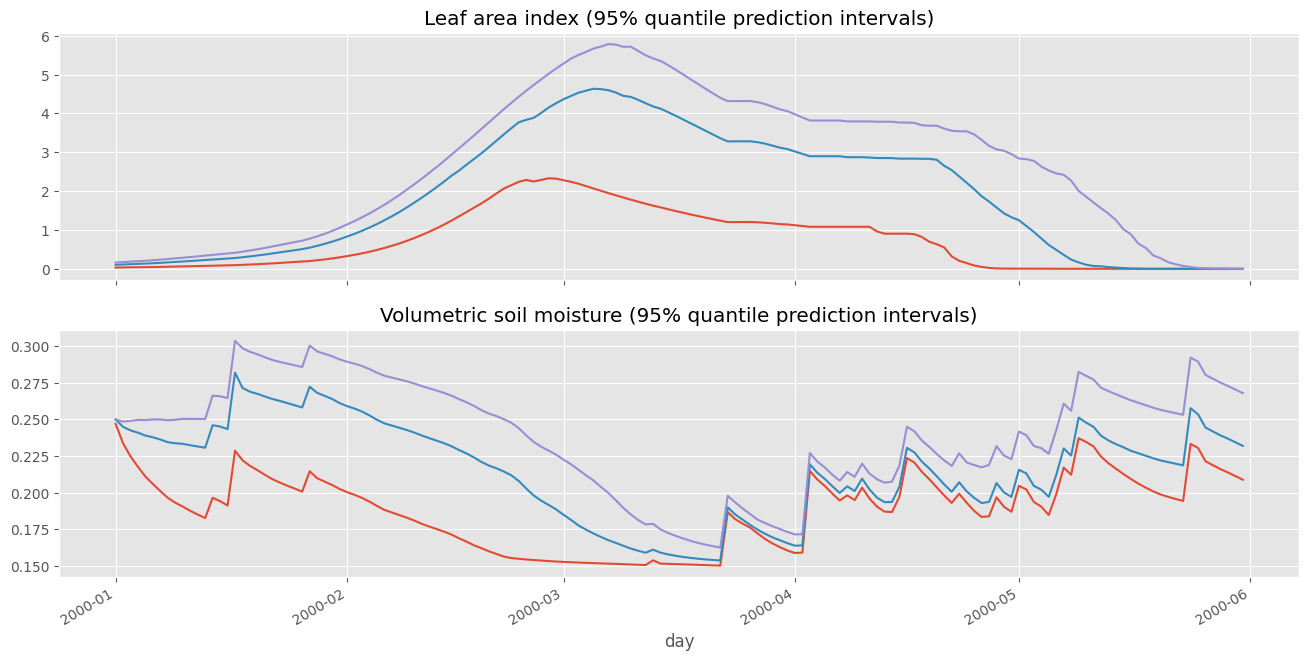

In [6]:
for i, member_df in enumerate(results):
    member_df["sim_id"] = i
    member_df["observed_LAI"] = observed_df["LAI"]
    member_df["observed_SM"] = observed_df["SM"] 
ensemble_results_df = pd.concat(results)[["sim_id", "LAI", "SM", "observed_SM"]]
ensemble_results_df

def q1(x):
    return x.quantile(0.025)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.975)

agg = {'LAI': [q1, q2, q3], "SM": [q1, q2, q3]}

combined_results = ensemble_results_df.groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_results["SM_q1"].plot(ax=axes[1])
combined_results["SM_q2"].plot(ax=axes[1])
combined_results["SM_q3"].plot(ax=axes[1])
axes[0].set_title("Leaf area index (95% quantile prediction intervals)")
axes[1].set_title("Volumetric soil moisture (95% quantile prediction intervals)")
fig.autofmt_xdate()

# Ensemble (with assimilation)

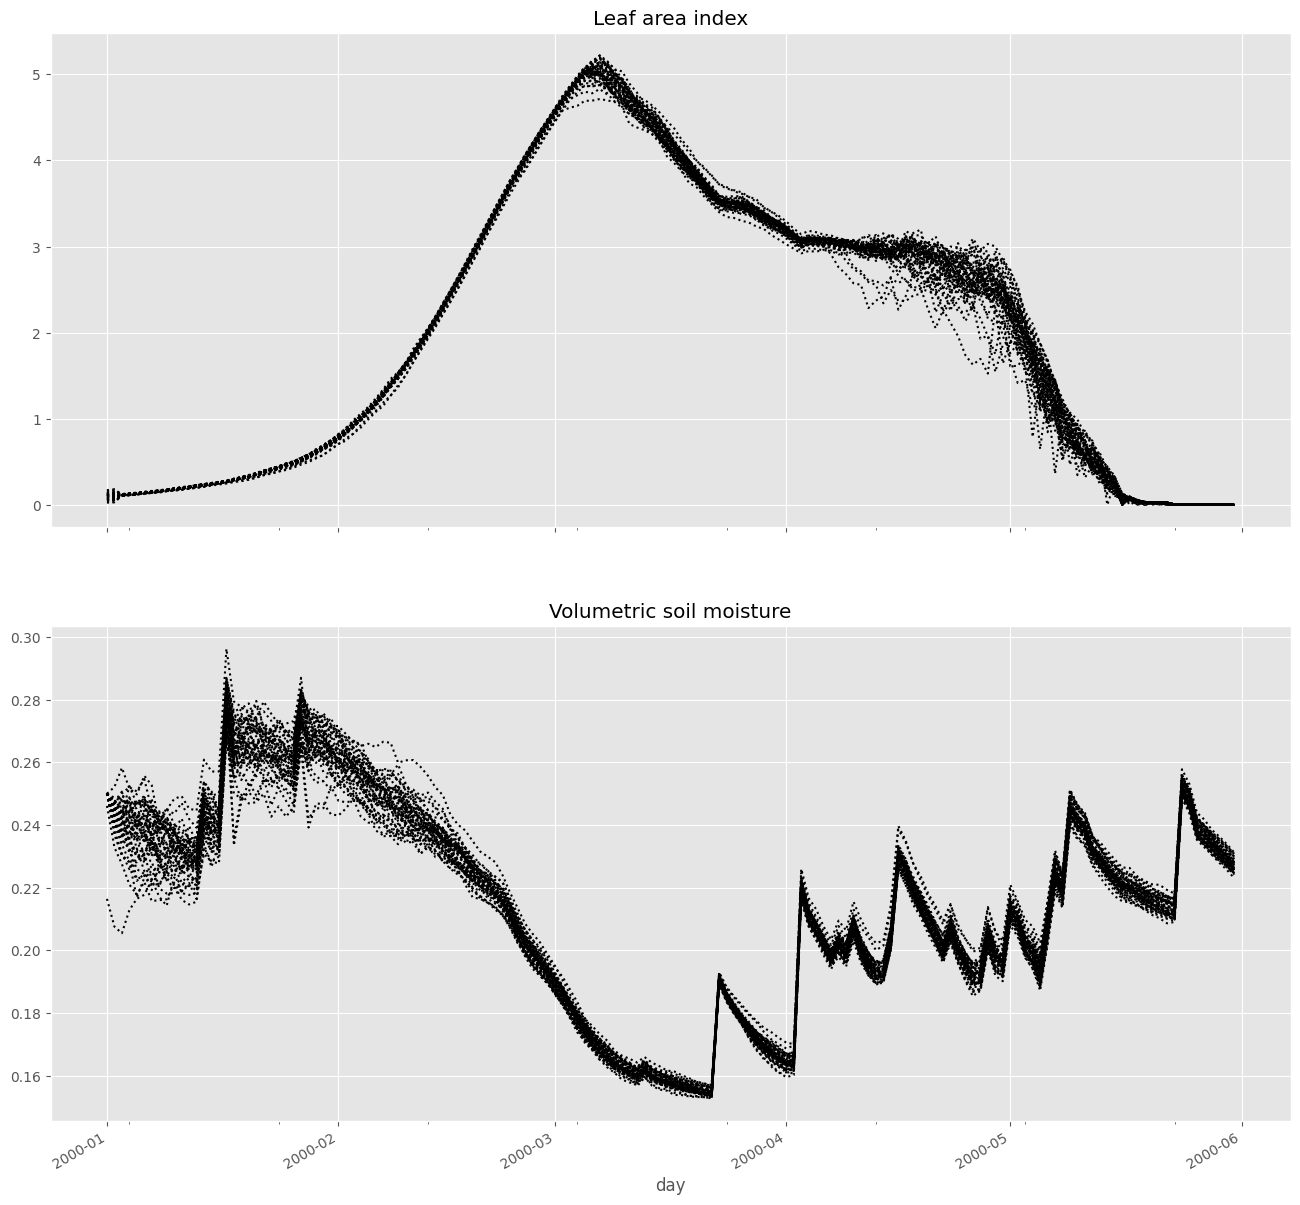

In [18]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

variables_for_DA = ["LAI", "SM"]
show_output = True
for day, row in observed_df.iterrows():
    collected_states = []
    for member in ensemble:
        member.run(1)
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A, dtype=float).T
    if np.isnan(A).any():
        continue
    P_e = np.matrix(df_A.cov())
    perturbed_obs = []
    for state in variables_for_DA:
        value = row[state]
        std = value * 0.05
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())

    H = np.identity(len(variables_for_DA))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)

    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    for member, new_states in zip(ensemble, df_Aa.itertuples()):
        r1 = member.set_variable("LAI", new_states.LAI)
        r2 = member.set_variable("SM", new_states.SM)
    
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

# Ensemble quantiles (with assimilation)

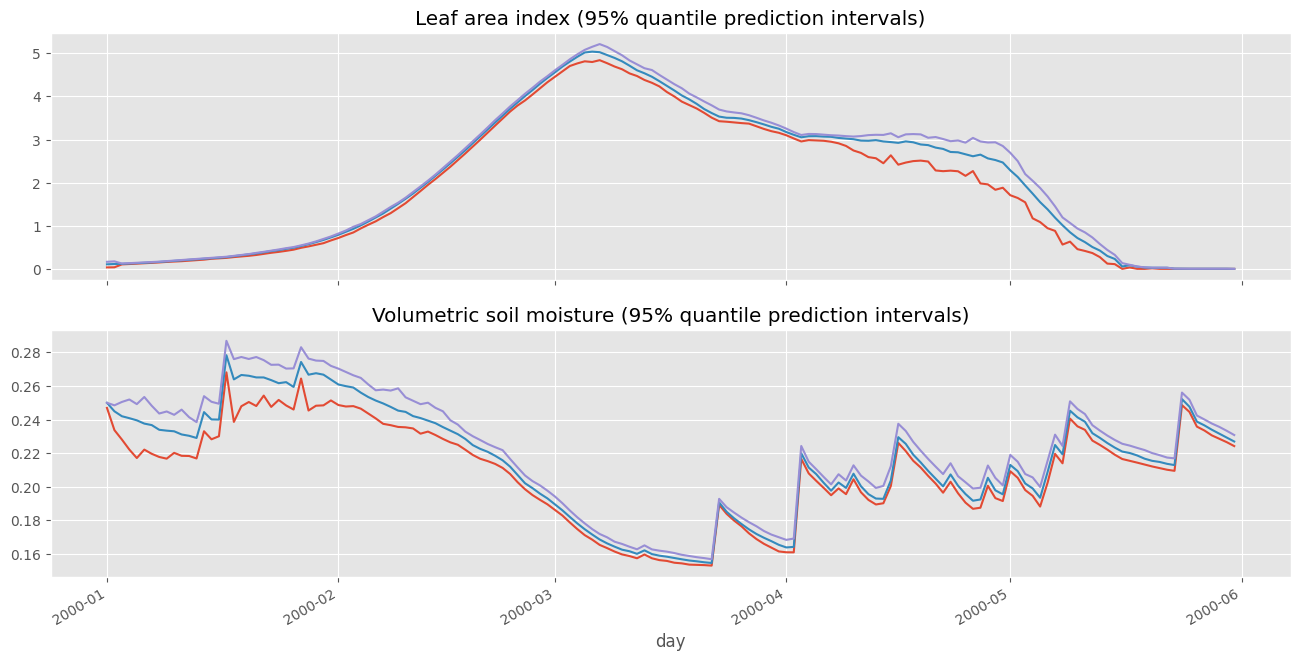

In [19]:
for i, member_df in enumerate(results):
    member_df["sim_id"] = i
    member_df["observed_LAI"] = observed_df["LAI"]
    member_df["observed_SM"] = observed_df["SM"] 
ensemble_results_df = pd.concat(results)[["sim_id", "LAI", "SM", "observed_SM"]]
ensemble_results_df

def q1(x):
    return x.quantile(0.025)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.975)

agg = {'LAI': [q1, q2, q3], "SM": [q1, q2, q3]}

combined_results = ensemble_results_df.groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_results["SM_q1"].plot(ax=axes[1])
combined_results["SM_q2"].plot(ax=axes[1])
combined_results["SM_q3"].plot(ax=axes[1])
axes[0].set_title("Leaf area index (95% quantile prediction intervals)")
axes[1].set_title("Volumetric soil moisture (95% quantile prediction intervals)")
fig.autofmt_xdate()

# Serial hybrid

In [94]:
value_col = "SM"
pivot_df = ensemble_results_df.reset_index().pivot(index='day', columns='sim_id', values=[value_col])
pivot_df.columns = pivot_df.columns.get_level_values(1)
pivot_df["observed_SM"] = observed_df[value_col] 
pivot_df

sim_id,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,observed_SM
day,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.216435,0.250000,0.250000,0.250000,0.250000,0.250000
2000-01-02,0.240515,0.246751,0.244890,0.245105,0.245402,0.245226,0.241146,0.243885,0.244748,0.241344,...,0.247783,0.238462,0.247449,0.245574,0.207574,0.247072,0.241634,0.248687,0.244401,0.244819
2000-01-03,0.238390,0.246916,0.242107,0.243493,0.240645,0.246040,0.236664,0.241337,0.241900,0.236505,...,0.243124,0.230966,0.248612,0.241522,0.205465,0.243802,0.236583,0.247632,0.239413,0.242331
2000-01-04,0.232472,0.243094,0.248330,0.247331,0.241486,0.245316,0.239826,0.240697,0.237758,0.240885,...,0.243960,0.225910,0.244974,0.236326,0.212842,0.244962,0.234826,0.246956,0.240801,0.240616
2000-01-05,0.222722,0.247062,0.247011,0.246394,0.239553,0.243153,0.237201,0.236782,0.241973,0.232421,...,0.240428,0.229424,0.240747,0.235501,0.216481,0.245431,0.231402,0.239042,0.239563,0.238408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-27,0.236505,0.239049,0.232871,0.236600,0.237727,0.236278,0.234957,0.235090,0.241725,0.233480,...,0.236299,0.236537,0.240039,0.234827,0.237364,0.239572,0.239775,0.238722,0.236244,0.240065
2000-05-28,0.233941,0.236536,0.230463,0.234237,0.234355,0.233876,0.232630,0.232657,0.238435,0.231676,...,0.233480,0.233669,0.236520,0.232778,0.233925,0.236887,0.237206,0.236237,0.234231,0.237451
2000-05-29,0.231968,0.230805,0.227937,0.232151,0.232067,0.231191,0.229820,0.230718,0.236316,0.230058,...,0.230783,0.231241,0.233925,0.230797,0.232503,0.234443,0.235702,0.233684,0.232167,0.235169


# Data split

In [411]:
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.cos import CosineTransformer
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.panel.rocket import MiniRocket
from sktime.transformations.series.date import DateTimeFeatures

y_pipeline = TransformerPipeline(steps = [
    BoxCoxTransformer() 
])

predictor_cols = list(range(ensemble_size))
pivot_df.index = pd.to_datetime(pivot_df.index)
pivot_df.index = pd.DatetimeIndex(df.index, freq="D")

dt_transformer = DateTimeFeatures(ts_freq="D")
X = pivot_df[predictor_cols]
# X = X.join(dt_transformer.fit_transform(X))

y = pivot_df["observed_SM"]
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)  

y_train = y_pipeline.fit_transform(y_train)
y_test = y_pipeline.transform(y_test)

/home/jbris/.cache/pypoetry/virtualenvs/wofost-data-assimilation-6XmudJaj-py3.10/lib/python3.10/site-packages/sktime/transformations/series/date.py:447: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(


# Hybrid

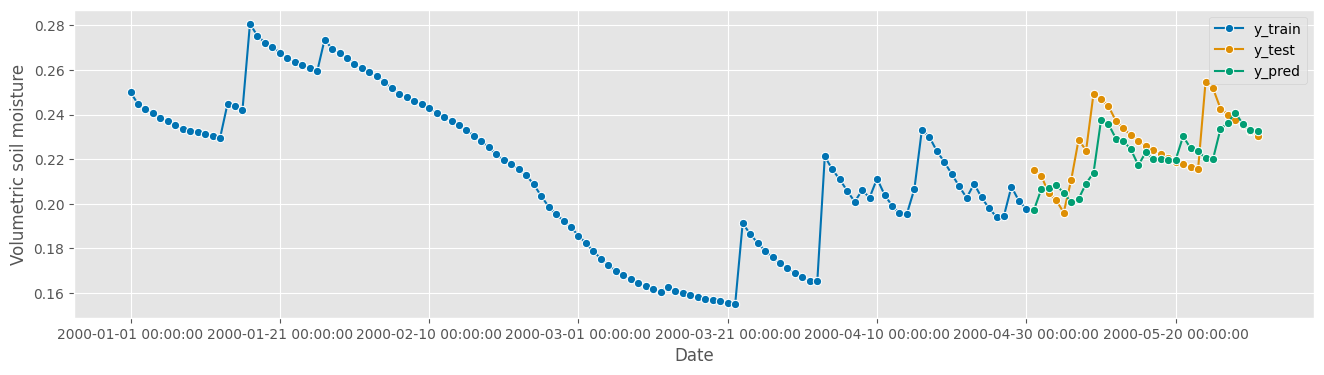

In [412]:
from sktime.forecasting.compose import AutoEnsembleForecaster, EnsembleForecaster
from sktime.forecasting.compose import StackingForecaster
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, TheilSenRegressor, QuantileRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sktime.forecasting.conformal import ConformalIntervals
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.squaring_residuals import SquaringResiduals

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecasters = []
for regressor in [
    KNeighborsRegressor(n_neighbors = 8), LinearRegression(), Ridge()
]:
    forecaster_name = regressor.__class__.__name__
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=24)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))),
            ("forecast", make_reduction(regressor, window_length=12, strategy="recursive")),
        ]
    )
    forecasters.append((forecaster_name, forecaster))
    
forecaster = EnsembleForecaster(forecasters=forecasters, aggfunc="median", n_jobs = -1)

forecaster.fit(y=y_train, X=X_train, fh=fh)
y_pred = y_pipeline.inverse_transform(forecaster.predict(fh=fh, X=X_test))

plot_series(
    y_pipeline.inverse_transform(y_train), 
    y_pipeline.inverse_transform(y_test), 
    y_pred, 
    labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Volumetric soil moisture',
);


/home/jbris/.cache/pypoetry/virtualenvs/wofost-data-assimilation-6XmudJaj-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jbris/.cache/pypoetry/virtualenvs/wofost-data-assimilation-6XmudJaj-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jbris/.cache/pypoetry/virtualenvs/wofost-data-assimilation-6XmudJaj-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jbris/.cache/pypoetry/virtualenvs/wofost-data-assimilation-6XmudJaj-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: Futu

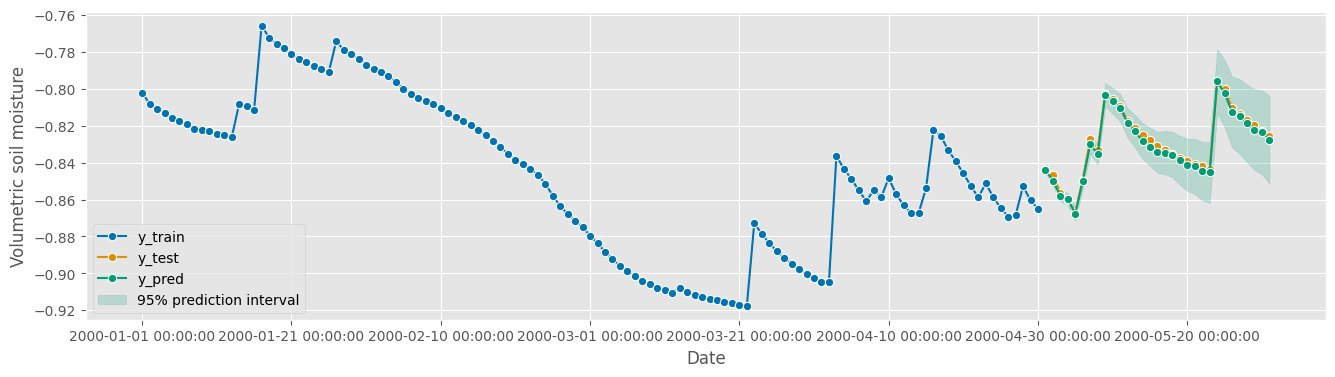

In [423]:
from sktime.forecasting.sarimax import SARIMAX

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = SARIMAX(
    order=(1, 1, 1), trend="t", seasonal_order=(1, 1, 1, 6), maxiter = 500
)
forecaster.fit(y=y_train, X=X_train, fh=fh)
pred_interval = forecaster.predict_interval(X=X_test, fh=fh, coverage=0.95)
y_pred = forecaster.predict(fh=fh, X=X_test) 

plot_series(
    y_train, 
    y_test, 
    y_pred,
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Volumetric soil moisture',
    pred_interval = pred_interval 
);